<a href="https://colab.research.google.com/github/Naidala/CNN_medical_imaging/blob/main/Task4_AlsoHealthy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
EPOCHS = 55
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (150, 150, 1)

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import copy


############################

def plot_acc_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

############################
drive.mount('/content/drive/')
out_path = "/content/drive/My Drive/CompIntProjects/FinalProject2019/numpy data/"

def load_data():
  train_images = np.load(os.path.join(out_path,'train_tensor.npy'))
  train_labels = np.load(os.path.join(out_path,'train_labels.npy'))
  test_images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  test_labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  train_images = train_images.astype('float32') / 65535   #BW 16-bit
  train_images = train_images.reshape((len(train_images), 150, 150, 1))
  test_images = test_images.astype('float32') / 65535
  test_images = test_images.reshape((len(test_images), 150, 150, 1))
  return train_images, train_labels, test_images, test_labels


def split_patch():      # store abnormal and corrisponding normal patch, in two vector but same order
  train_images, train_labels, test_images, test_labels = load_data()
  train_images_norm = train_images[0:len(train_images):2]
  train_images_ab = train_images[1:len(train_images):2]
  train_labels_norm = train_labels[0:len(train_labels):2]
  train_labels_ab = train_labels[1:len(train_labels):2]
  test_images_norm = test_images[0:len(test_images):2]
  test_images_ab = test_images[1:len(test_images):2]
  test_labels_norm = test_labels[0:len(test_labels):2]
  test_labels_ab = test_labels[1:len(test_labels):2]
  for i in range(0,len(test_labels_norm)):
    train_labels_norm[i] = train_labels_ab[i]
    test_labels_norm[i] = test_labels_ab[i]
  abnormal = [train_images_ab, train_labels_ab, test_images_ab, test_labels_ab]
  normal = [train_images_norm, train_labels_norm, test_images_norm, test_labels_norm]
  return abnormal, normal

def split_for_augment(train_images, train_labels):
  np.random.seed(5)
  np.random.shuffle(train_images)
  np.random.seed(5)
  np.random.shuffle(train_labels)
  PERCENTAGE_VALIDATION = 0.2
  num_validation_samples = round(len(train_labels)*PERCENTAGE_VALIDATION)
  my_val_images = copy.deepcopy(train_images[:num_validation_samples])
  my_val_labels = copy.deepcopy(train_labels[:num_validation_samples])
  my_train_images = copy.deepcopy(train_images[num_validation_samples:])
  my_train_labels = copy.deepcopy(train_labels[num_validation_samples:])
  return my_train_images, my_train_labels, my_val_images, my_val_labels

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from tensorflow.keras.utils import to_categorical
def labels_in_four(labels):
  for i in range(0,len(labels)):
    labels[i] = labels[i] - 1
  return to_categorical(labels, num_classes = 4)

abnormal, normal = split_patch()
abnormal[1] = labels_in_four(abnormal[1])

test_labels = labels_in_four(abnormal[3])
test_images_ab = abnormal[2]
test_images_norm = normal[2]

train_images_ab, train_labels_ab, val_images_ab, val_labels_ab = split_for_augment(abnormal[0], abnormal[1])
train_images_norm, train_labels_norm, val_images_norm, val_labels_norm = split_for_augment(normal[0], normal[1])

In [ ]:
#Create a standard ImageDataGenerator, then use a helper function to return multiple inputs
# as a list along with the y values necessary to train using fit_generator
gen = ImageDataGenerator(rotation_range = 20,
                         shear_range = 0.3,
                         zoom_range = 0.5,
                         height_shift_range = 0.1,
                         width_shift_range = 0.1,
                         horizontal_flip = True,
                         vertical_flip = True,
                         fill_mode = 'nearest')

# We found this function, to be used to merge our two generators
# and let us use fit_generator for two augmented set of data.
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=BS,seed=666)
    genX2 = gen.flow(X1,X2, batch_size=BS,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[1]], X1i[1]  #Yield both images and their mutual label

# Finally create generator
gen_flow = gen_flow_for_two_inputs(train_images_ab, train_images_norm, train_labels_ab)

In [ ]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate

# define two sets of inputs
inputA = Input(shape=(150, 150, 1))
inputB = Input(shape=(150, 150, 1))
# the first branch operates on the first input
x = Conv2D(32, (3, 3), activation="relu")(inputA)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Conv2D(32, (3, 3), activation="relu")(inputB)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation="relu")(y)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(128, (3, 3), activation="relu")(y)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(128, (3, 3), activation="relu")(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])

z = Dropout(0.6)(combined)
z = Dense(173, activation="relu")(combined)
z = Dense(4, activation="sigmoid")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
opt = Adam(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])

history = model.fit_generator(
                      gen_flow,
                      validation_data = ([val_images_ab, val_images_norm], val_labels_ab),
                      steps_per_epoch = len(train_labels_ab) // BS,
                      epochs = EPOCHS,
                      validation_steps = len(val_labels_ab) // BS,
                      shuffle = True)

Epoch 1/55
66/66 [==============================] - 9s 136ms/step - loss: 1.3651 - acc: 0.3490 - val_loss: 1.3640 - val_acc: 0.3495
Epoch 2/55
66/66 [==============================] - 8s 124ms/step - loss: 1.3575 - acc: 0.3542 - val_loss: 1.3472 - val_acc: 0.3664
Epoch 3/55
66/66 [==============================] - 9s 129ms/step - loss: 1.3540 - acc: 0.3589 - val_loss: 1.3384 - val_acc: 0.3720
Epoch 4/55
66/66 [==============================] - 9s 129ms/step - loss: 1.3495 - acc: 0.3651 - val_loss: 1.2974 - val_acc: 0.3533
Epoch 5/55
66/66 [==============================] - 9s 130ms/step - loss: 1.3459 - acc: 0.3599 - val_loss: 1.3278 - val_acc: 0.3645
Epoch 6/55
66/66 [==============================] - 9s 129ms/step - loss: 1.3483 - acc: 0.3623 - val_loss: 1.2850 - val_acc: 0.3607
Epoch 7/55
66/66 [==============================] - 9s 130ms/step - loss: 1.3174 - acc: 0.3575 - val_loss: 1.3120 - val_acc: 0.3495
Epoch 8/55
66/66 [==============================] - 9s 131ms/step - loss: 1.

In [ ]:
test_loss, test_acc = model.evaluate([test_images_ab,test_images_norm], test_labels)
print('test_acc: ', test_acc)

336/336 [==============================] - 0s 794us/step
test_acc:  0.488095223903656


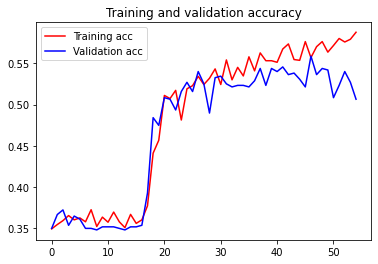

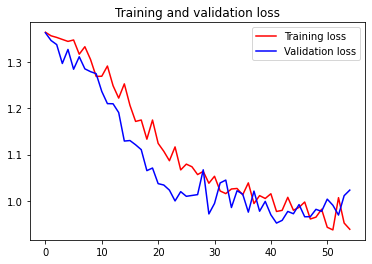

32


In [ ]:
plot_acc_loss(history)

In [ ]:
#save_dir = "/content/drive/My Drive/CompIntProjects/Task4"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'alsoHealthy.h5'))